<a href="https://colab.research.google.com/github/valerio-unifei/UNIFEI-IA-Aulas/blob/main/TFG_WSU_CASAS_ML_EduardoPapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset CASAS

http://casas.wsu.edu/datasets/

Dataset 21 - Kyoto, Cognitive assessment activity data,	Annotated= Yes, Update = 2013-02-23

In [1]:
# baixando dataset do site original
!wget "http://casas.wsu.edu/datasets/assessmentdata.zip"
# descompactando dataset
!unzip -qq assessmentdata.zip
# apagando arquivo compactado
!rm assessmentdata.zip

--2021-08-03 17:34:21--  http://casas.wsu.edu/datasets/assessmentdata.zip
Resolving casas.wsu.edu (casas.wsu.edu)... 134.121.67.111
Connecting to casas.wsu.edu (casas.wsu.edu)|134.121.67.111|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12632274 (12M) [application/zip]
Saving to: ‘assessmentdata.zip’

assessmentdata.zip  100%[===================>]  12.05M  6.34MB/s    in 1.9s    

2021-08-03 17:34:23 (6.34 MB/s) - ‘assessmentdata.zip’ saved [12632274/12632274]



#Carregando Dataset

https://medium.com/@nickmal/real-time-activity-recognition-in-a-smart-home-using-binary-sensors-efd147ec694

Listando arquivos extraídos do zip na pasta 'data'.

In [2]:
import glob
# listando arquivos de eventos .txt
arquivos = glob.glob('assessmentdata/data/*.txt')
# ordenando por nome
arquivos.sort()
# quantidade, primeiro, último
len(arquivos), arquivos[0],arquivos[-1]

(400, 'assessmentdata/data/001.txt', 'assessmentdata/data/400.txt')

Carregando arquivo com diagnósticos por participante na pasta 'documents'

Diagnosis
- 1 = dementia
- 2 = MCI
- 3 = middle age 45-59
- 4 = young-old 60-74
- 5 = old-old 75+
- 6 = other medical
- 7 = watch/at risk - follow longitudinally
- 8 = younger adult
- 9 = younger adult, English second language
- 10 = diagnosis not available

In [3]:
import pandas as pd
# arquivo de diagnóstico por voluntário (id do arquivo txt)
diagnosticos = pd.read_csv('assessmentdata/documents/diagnosis.txt',sep=' ',skiprows=14)
# trocando diagnóstico por enfermidade (0-não, 1-sim)
diagnosticos['Diagnosis']  = diagnosticos['Diagnosis'].replace(
    [1,2,3,4,5,6,7,8,9,10],
    [1,1,0,0,1,1,1,0,0,1], #1, 2, 6, 7
    )
# número de diagnósticos (deve ser igual ao número de arquivos)
len(diagnosticos)

400

# Pré-Processamento do Dataset

Carregando os arquivos de pacientes por hora, sensor, valor e descrição.

In [ ]:
import os
from tqdm import tqdm
# dataset final
casas2 = None
#parametros
intervalo_segundos = 5*60


for i in tqdm(range(len(arquivos)), position=0, leave=True):
  arq = arquivos[i]
  #somente arquivos com tamanho superior a 20 bytes
  if os.stat(arq).st_size > 20:
    # estrai dados do arquivo texto
    ds = pd.read_csv(arq,header=None, sep=' ', 
                     names=['instante', 'sensor', 'value', 'description'], 
                     dtype={'x2': str})
    # converte instante para segundos e divisão inteira do intervalo
    ds['minutes'] = pd.to_timedelta(ds['instante'], errors='coerce').dt.total_seconds()
    ds['minutes'] =  ds['minutes'].map(lambda x: x // intervalo_segundos)

    #lista apenas sensores de movimento e portas
    ss = ds['sensor'].str.startswith('M0') | ds['sensor'].str.startswith('D0')

    #monta tabela de sensores selecionados
    sensores = None
    sensores = pd.DataFrame(ds.loc[ss,'minutes'],columns=['minutes'])
    sensores['sensor'] = ds.loc[ss,'sensor']
    sensores['value'] = ds.loc[ss,'value'].replace(['ON','OFF','OPEN','CLOSE'],[2,1,2,1])
    sensores['value'] = pd.to_numeric(sensores['value'],errors='coerce')
    # gira tabela onde colunas são os nomes dos sensores, linhas o intervalo de tempo e valores máximos nas celulas
    sensores = pd.pivot_table(sensores,values='value',index='minutes',columns='sensor',aggfunc='max')
    # pega diagnóstico do indivíduo do arquivo
    nome = os.path.basename(arq)
    filenum = int(os.path.splitext(nome)[0])
    diag = diagnosticos.loc[diagnosticos['ID']==filenum,'Diagnosis'].values[0]
    sensores['tutor'] = [diag] * len(sensores)

    # interpola valores das colunas anteriores ou posteiores, removendo NaN
    sensores = sensores.interpolate(axis=1,limit_direction='both')
    sensores = sensores.dropna() #remove linhas com NaN mesmo interpolando

    # incorpora dataset do arquivo no conjunto final
    if casas2 is None:
      casas2 = sensores.copy()
    else:
      casas2 = casas2.append(sensores)

    del sensores

# caso exista NaN substitui com zero
casas2 = casas2.fillna(0)

#extrai atributos e tutor
colunas = [x for x in casas2.columns if x != 'tutor']
X = casas2[colunas].values
y = casas2['tutor'].values

Matriz de correlação dos atributos de entrada e tutor

,D001,D007,D009,D010,D012,D014,D015,M001,M002,M003,M005,M006,M007,M008,M009,M010,M011,M013,M014,M015,M016,M017,M018,M019,M020,M021,M022,M023,M024,M025,M026,M027,M028,M029,M042,M043,M051,D004,D005,D006,M004,M012,M037,M038,M039,M040,M041,M044,M050,M052,D013,D003,D008,M030,M031,M036,M034,M035,D002,M032,M033,M045,M046,M047,M048,M049,D011,D016,D017,D018,tutor
minutes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.894737,1.789474,1.684211,1.578947,1.473684,1.368421,1.263158,1.157895,1.052632,0.947368,0.842105,0.736842,0.631579,0.526316,0.421053,0.315789,0.210526,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109.0,1.0,1.0,1.0,1.5,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110.0,1.0,1.0,1.0,1.5,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(11054, 71)

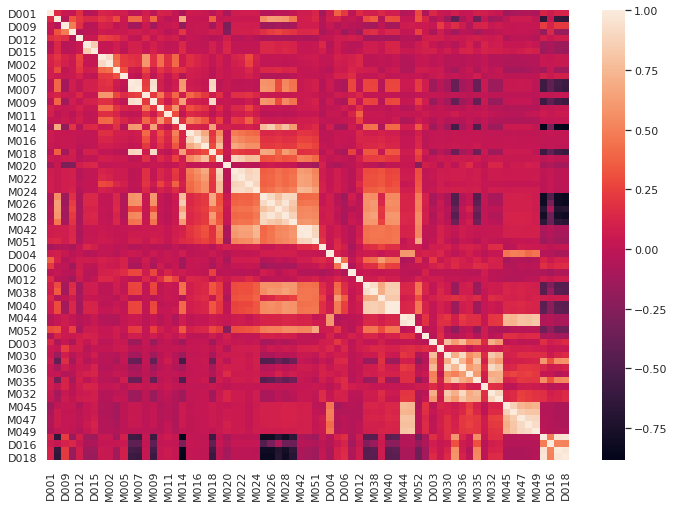

In [19]:
# ve correlação da colunas
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(casas2.corr())

#exibe parte da tabela
display(casas2[colunas + ['tutor']].head())
casas2.shape

#Aprendizado de Máquina

##Treinamento com validação cruzada

In [20]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from sklearn.model_selection import cross_validate

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

from sklearn.neural_network import MLPClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

classificadores = [
  DecisionTreeClassifier(random_state=42),
  SVC(),
  MLPClassifier(),
  GaussianNB(),
  RandomForestClassifier(),
  AdaBoostClassifier(),
  ExtraTreeClassifier(),
  LinearSVC(),
  BernoulliNB(),
  #RadiusNeighborsClassifier(),
  KNeighborsClassifier(),
  SGDClassifier(),
  RidgeClassifier(),
  PassiveAggressiveClassifier(),
  Perceptron(),
  GradientBoostingClassifier(),
  BaggingClassifier(),
  QuadraticDiscriminantAnalysis(),
  LinearDiscriminantAnalysis(),
]

cv = 3

resultados = []
for i in tqdm(range(len(classificadores)), position=0, leave=True):

  clf = classificadores[i]
  rl = []
  rl.append(clf.__class__.__name__)
  cvr = cross_validate(
      clf, 
      X_train, y_train, 
      cv=cv, 
      scoring=['accuracy','recall_macro','f1_macro'], 
      n_jobs=-1,

      )
  rl.append(sum(cvr['fit_time'])/cv)
  rl.append(sum(cvr['test_accuracy'])/cv)
  rl.append(sum(cvr['test_f1_macro'])/cv)
  rl.append(sum(cvr['test_recall_macro'])/cv)
  resultados.append(rl)

100%|██████████| 18/18 [00:39<00:00,  2.21s/it]


Resultado Final de avaliação dos métodos de aprendizado baseado nas métricas utilizadas.

In [21]:
cv_res = pd.DataFrame(resultados, columns=['Classificador','treinamento(s)','Acurácia','F1','Recall'])
cv_res.sort_values(by='Acurácia',ascending=False)

,Classificador,treinamento(s),Acurácia,F1,Recall
5,AdaBoostClassifier,0.589493,0.722764,0.718572,0.719563
15,BaggingClassifier,0.388869,0.705239,0.700652,0.701947
14,GradientBoostingClassifier,2.117803,0.700813,0.696454,0.697769
0,DecisionTreeClassifier,0.064862,0.690515,0.685628,0.687344
4,RandomForestClassifier,0.766290,0.680488,0.677020,0.678200
9,KNeighborsClassifier,0.131878,0.618880,0.612504,0.614687
6,ExtraTreeClassifier,0.011479,0.616260,0.612769,0.613419
1,SVC,3.741032,0.614182,0.609091,0.611899
2,MLPClassifier,6.385907,0.599277,0.592940,0.595621
12,PassiveAggressiveClassifier,0.041157,0.598916,0.588560,0.602191


In [31]:
cv_res.to_csv('cv_res.csv',index=False,float_format='%.3f')